# [WSI] Ćwiczenie nr 2
### Algorytmy ewolucyjne

Mikołaj Wewiór 318407


## pytania

-> funkcja dopasowania </br>
-> złożoność obliczeniowa - na dole pierwszej strony polecenia </br>
-> czy mutacja może dawać gorsze wyniki </br> 
-> czy krzyżowanie może tylko brać na współrzędną X tylko x1 lub x2 i analogicznie dla Y, czy to może być losowa kombinacja z listy [x1, y1, x2, y2] </br>

In [275]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy


RAST_BOUNDS = [-5.12, 5.12]
GRIE_BOUNDS = [-50, 50]
DROP_BOUNDS = [-3, 3]


DIMENSIONS = 2
PLOT_STEPS = 200
PLOT_COLOR = "turbo"
BEST_COLOR = "magenta"
# viridis # plasma # inferno # magma # cividis
# cubehelix # gist_earth # turbo # terrain


ITERATIONS = 1000
POPULATION = 25
PC = 0.5
PM = 0.9
SIGMA = 2.2
ELITE_SUCCESSION = 1


EVIL_GLOBAL_VAR = []


In [276]:
class Function:

    def __init__(self, bounds, dimensions, global_optimum=0.0):
        self._name = None
        self._bounds = bounds
        self._dimensions = dimensions
        self._global_optimum = global_optimum


    def name(self):
        return self._name


    def dimension(self):
        return self._dimensions


    def bounds(self):
        return self._bounds

    def bound(self):
        return max(self.bounds())


    # def position(self):
    #     return self._current_position


    # def set_position(self, new_position):
    #     self._current_position = new_position


    # def beta(self):
    #     return self._beta


    # def set_beta(self, new_beta):
    #     self._beta = new_beta


    def global_optimum(self):
        return self._global_optimum


    # def grad(self, x_vector, i):
    #     return None

    def q(self):
        pass

    def update_position(self):
        pass
        # TODO

        # min_bound = self._bounds[0]
        # max_bound = self._bounds[1]
        # d = self.d()
        # x = copy.deepcopy(self.position())

        # for i in range(d):
        #     upd = self.beta()*self.grad(x, i)
        #     x[i] = x[i] - upd

        #     while x[i] > max_bound:
        #         diff = x[i] - max_bound
        #         x[i] = min_bound + diff
        #     while x[i] < min_bound:
        #         diff = x[i] - min_bound
        #         x[i] = max_bound + diff

        # self.set_position(x)
        # return x


In [277]:
class Rastrigin(Function):

    def __init__(self, bounds, dimensions):
        super().__init__(bounds, dimensions)
        self._name = "Rastrigin"

    # TODO

    def q(self, x_vector):
        d = self.dimension()
        partial_cost = lambda x: x**2 - 10*np.cos(2*np.pi*x)

        cost = 10*d
        for i in range(d) : cost += partial_cost(x_vector[i])

        return cost


    # def grad(self, x_vector, i):
    #     x = x_vector[i]
    #     gradient = 2*x +20*np.pi*np.sin(2*np.pi*x)
    #     return gradient


In [278]:
class Griewank(Function):

    def __init__(self, bounds, dimensions):
        super().__init__(bounds, dimensions)
        self._name = "Griewank"

    # TODO

    def q(self, x_vector):
        d = self.dimension()

        SUM = 0
        for i in range(d):
            SUM += x_vector[i]**2
        SUM = SUM / 4000

        PI = 1
        for i in range(d):
            PI = PI*np.cos(
                x_vector[i]*np.sqrt(i+1)/(i+1)
            )

        return SUM - PI + 1


    # def grad(self, x_vector, i):
    #     x = x_vector
    #     PI_rest = 1
    #     for j in range(self.d()):
    #         if j != i:
    #             PI_rest = PI_rest*np.cos(
    #                 x[j]*np.sqrt(j+1)/(j+1)
    #             )

    #     return x[i]/2000 + np.sin(x[i]*np.sqrt(i+1)/(i+1)) * PI_rest*np.sqrt(i+1)/(i+1)


In [279]:
class DropWave(Function):
    def __init__(self, bounds, dimensions, global_optimum=0.0):
        super().__init__(bounds, dimensions, global_optimum)
        self._name = "DropWave"

    # TODO

    def q(self, x_vector):
        d = self.dimension()

        square = 0
        for i in range(d):
            square += x_vector[i]**2

        numerator = 1 + np.cos(12*np.sqrt(square))
        denominator = 0.5 * square + 2

        return 1-numerator/denominator


In [280]:
class Quadratic(Function):

    def __init__(self, bounds, dimensions, global_optimum=0.0):
        super().__init__(bounds, dimensions, global_optimum)
        self._name = "Quadratic"


    def q(self, x_vector):
        d = self._dimensions

        cost = 0
        for i in range(d):
            cost += (x_vector[i])**2

        return cost

In [281]:
class Particle:
    def __init__(self, id: int, position: list, function: Function):
        self._id = id
        self._position = position
        self._function = function
        self._rank = None
        self.q = None

    def function(self) -> Function:
        return self._function

    def id(self) -> int:
        return self._id

    def position(self) -> list:
        return self._position

    def value(self) -> float:
        return self.q

    def set_value(self):
        x = self.position()
        self.q = self.function().q(x)

    def set_rank(self, rank):
        self._rank = rank

    def rank(self) -> float:
        return self._rank

    def fix_position(self, index) -> float:
        i = index
        if self.position()[i] > self.function().bounds()[1]:
            return self.function().bounds()[1]
        if self.position()[i] < self.function().bounds()[0]:
            return self.function().bounds()[0]
        return self.position()[i]


    def print(self):
        print(f'{self.id()} | {self.position()} | {self.q} | {self.value()} | {self.function().name()}')

In [282]:
class Evolution:
    def __init__(self, function: Function, iterations: int, population_count: int, mutation_factor: float, crossing_factor: float, mutation_sigma: float = None, elite_succession : int = 1):

        def generate_population() -> list:
            bound = function.bound()
            population = []
            for id in range(population_count):
                x1 = np.random.uniform(-bound, bound)
                x2 = np.random.uniform(-bound, bound)
                particle = Particle(id+1, [x1, x2], function)
                particle.set_value()
                population.append(particle)
            return population

        self._function = function
        self._iterations = iterations
        self._population_count = population_count
        self._population = generate_population()
        self._mutation_factor = mutation_factor
        self._mutation_sigma = mutation_sigma
        self._crossing_factor = crossing_factor
        self._elite_successors = elite_succession
        self._current_best_fitness = None
        self._history_best_fitness = None

    def function(self) -> Function:
        return self._function

    def iterations(self) -> int:
        return self._iterations

    def population(self) -> list:
        return self._population

    def nominal_population_count(self) -> int:
        return self._population_count

    def current_population_count(self) -> int:
        return len(self.population())

    def pm(self) -> float:
        return self._mutation_factor

    def pc(self) -> float:
        return self._crossing_factor

    def sigma(self) -> float:
        return self._mutation_sigma

    def set_new_population(self, population):
        self._population = population

    def sort_population(self):
        self.population().sort(key = lambda p: p.value())
        self._current_best_fitness = self.population()[0]

    def best_fitness(self) -> Particle:
        return self._current_best_fitness

    def best_history_fitness(self) -> Particle:
        history_best = self._history_best_fitness
        if history_best is None:
            return self.best_fitness()
        return history_best

    def set_best_fitness(self, best_fitness):
        self._current_best_fitness = best_fitness
        if self._history_best_fitness is None:
            self._history_best_fitness = best_fitness
        elif best_fitness.value() < self._history_best_fitness.value():
            self._history_best_fitness = best_fitness


    def fitness_func(self):
        for particle in self.population(): particle.set_value()
        self.sort_population()

        # best_fitness = self.best_fitness()
        best_fitness = self.best_history_fitness()
        # best_fitness = self.population()[0]
        # EVIL_GLOBAL_VAR.append(best_fitness.value())
        best_fitness.set_rank(1)
        best_value = best_fitness.value()

        for particle in self.population()[1::]:
            r = 1 + (particle.value() - best_value)**2
            particle.set_rank(r)

        # if we would know global optimum at start:
        # for particle in self.population():
        #     r = 0
        #     for d in range(self.function.dimention()):
        #         r += particle.position()[d]**2
        #     particle.set_rank(np.sqrt(r))




    def crossover(self, first_parent: Particle):
        a = np.random.random()
        if a < self.pc():
            particle = Particle(first_parent.id(), [], self.function())
            second_parent = random.choice(self.population())
            possible_position = []

            # for parent in [first_parent, second_parent]:
            #     for d in range(self.function().dimension()):
            #         possible_position.append(parent.position()[d])

            for d in range(self.function().dimension()):
                possible_position.append([])
                for parent in [first_parent, second_parent]:
                    possible_position[d].append(parent.position()[d])

            for d in range(self.function().dimension()):
                new_pos = random.choice(possible_position[d])
                particle.position().append(new_pos)

        else:
            particle = first_parent

        return particle


    def mutation(self, particle: Particle):
        a = np.random.random()
        if a < self.pm():
            for i in range(self.function().dimension()):
                mut = self.sigma() * np.random.randn()
                particle.position()[i] += mut
                particle.position()[i] = particle.fix_position(i)



    def reproduction(self):
        reproduction = []
        # reproduction.append(self.best_fitness())
        while(len(reproduction) < self.nominal_population_count()-1):
            particle1 = random.choice(self.population())
            particle2 = random.choice(self.population())
            if particle1.rank() <= particle2.rank():
                reproduction.append(copy.deepcopy(particle1))
            else:
                reproduction.append(copy.deepcopy(particle2))
        self.set_new_population(reproduction)


    def succession(self):
        # other n-1 elements are going in sequence
        self.population().append(self.best_fitness())





    # inicjalizacja populacji
    # wartość funkcji dopasowania dla osobnika
    #   wybór osobników do krzyżowania
    #   krzyżowanie
    #   mutacja wybranych
    #   obliczenie wartości funkcji dopasowania dla każdego
    #   wybór nowej populacji



In [283]:
class Plotter:
    def __init__(self, function: Function, steps: int, bounds: list = None):
        self._function = function
        self._steps = steps
        self._dimensions = function.dimension()
        self._bounds = bounds


    def funciton(self):
        return self._function


    def name(self):
        return self.funciton().name()


    def d(self):
        return self._dimensions


    def steps(self):
        return self._steps


    def bounds(self):
        if self._bounds != None:
            return self._bounds
        return self.funciton().bounds()


    def q(self, x_vector):
        return self.funciton().q(x_vector)



    # def plot_route(self, route_x, route_y):
    #     plt.scatter(route_x[1:-1], route_y[1:-1])
    #     plt.plot(route_x, route_y)
    #     plt.scatter(route_x[0], route_y[0], color="white")
    #     plt.scatter(route_x[-1], route_y[-1], color="red")


    def plot(self, drow_online = False): #, route_x=None, route_y=None):
        step = self.steps()
        bounds = self.bounds()
        diff = bounds[1] - bounds[0]
        Z = np.zeros((step+1, step+1))
        for i in range(step+1):
            y = bounds[0] + i*diff/step
            for j in range(step+1):
                x = bounds[0] + j*diff/step
                Z[i][j] = self.q([x, y])

        x = np.linspace(bounds[0], bounds[1], step+1)
        y = np.linspace(bounds[0], bounds[1], step+1)

        X, Y = np.meshgrid(x, y)

        plt.figure()
        plt.ion()

        contour = plt.contourf(X, Y, Z, cmap=PLOT_COLOR, levels=100)
        cbar = plt.colorbar(contour)
        cbar.set_label("Function value")

        plt.grid(True)
        plt.xlabel("x1")
        plt.ylabel("x2", rotation=0)

        # if not (route_x == None or route_y == None):
        #     self.plot_route(route_x, route_y)

        if not drow_online:
            plt.show()


    def draw_online(self, evolution: Evolution):
        plt.ion()

        # draw_grid(min_bound, max_bound, fun)
        self.plot(drow_online=True)

        # Wyświetlenie punktów
        X = []
        Y = []
        best_fitnesses = evolution.best_fitness().position()
        for particle in evolution.population():
            X.append(particle.position()[0])
            Y.append(particle.position()[1])
        plt.scatter(X, Y, c="w", marker=".")
        plt.scatter(best_fitnesses[0], best_fitnesses[1], c=BEST_COLOR, marker="*")
        # plot_points = plt.scatter(X, Y, c="w", marker=".")
        # plot_best_point = plt.scatter([], [], c="g", marker="o")

        plt.show()
        # return plot_points, plot_best_point

In [284]:
class Experiment:
    def __init__(self, function, iterations: int, step: float, experiment_domain: float, epsilon: float, show: bool):
        self._function = function
        self._iterations = iterations
        self._step = step
        self._domain = experiment_domain
        self._epsilon = epsilon
        self._show = show


    def test_function(self):
        return self._function


    def iterations(self):
        return self._iterations


    def step(self):
        return self._step


    def domain(self):
        return self._domain


    def epsilon(self):
        return self._epsilon


    def show_flag(self):
        return self._show


    def specify_function(self, function, x=None,  beta=None, MSE=False):
        if x != None:
            function.set_position(x)
        if beta != None:
            function.set_beta(beta)


    def plot(self, data, xlabel, scatter=False):
        X = data[0]
        Y = data[1::]
        plt.figure()
        plt.grid(True)
        for y in Y: plt.plot(X, y)
        if scatter:
            for y in Y: plt.scatter(X, y, c='#ff7f0e')
        plt.ylabel("Error")
        plt.xlabel(xlabel)
        plt.show()


    def beta_experiment(self, init_points, MSE=False):
        beta_and_qs = []
        for _ in range(len(init_points)+1): beta_and_qs.append([])

        int_range = int(self.domain() / self.step())

        for i in range(int_range+1):

            beta = (i+1)*self.step()
            beta_and_qs[0].append(beta)

            for t in range(len(init_points)):
                test_func = self.test_function()
                self.specify_function(test_func, init_points[t], beta)

                test = Test(self.iterations(), test_func, self.epsilon())
                route_x, route_y, route_q = test.do_test()

                if MSE:
                    error = route_q[-1]**2
                else:
                    error = abs(route_q[-1])

                beta_and_qs[t+1].append(error)

        if self.show_flag():
            self.plot(beta_and_qs, xlabel="Beta")

        return beta_and_qs


    def initial_position_experiment(self, inits_count, beta, distribution_bound, MSE=False):
        xy_results = [[], [], []]
        # bound = self.test_function().bounds()[1]

        for _ in range(inits_count):

            # x1 = np.random.uniform(-bound, bound)
            # x2 = np.random.uniform(-bound, bound)
            # x2 = np.random.normal(0, 3.0, 1)
            # x1 = np.random.normal(0, 3.0, 1)
            X = get_truncated_normal(0, 4, -distribution_bound, distribution_bound)
            x1 = X.rvs()
            x2 = X.rvs()
            position = [x1, x2]
            norm = np.sqrt(x1**2 + x2**2)

            xy_results[0].append(position)
            xy_results[1].append(norm)

            test_func = self.test_function()
            self.specify_function(test_func, position, beta)

            test = Test(self.iterations(), test_func, self.epsilon())
            route_x, route_y, route_q = test.do_test()

            if MSE:
                error = route_q[-1]**2
            else:
                error = abs(route_q[-1])

            xy_results[2].append(error)

        zipped = list(zip(xy_results[1], xy_results[2]))
        dist_q = sorted(zipped, key = lambda x: x[0])
        xs_and_qs = [
            [i for i, j in dist_q],
            [j for i, j in dist_q]
        ]

        if self.show_flag():
            self.plot(xs_and_qs, xlabel="Distance from global optimum", scatter=True)

        return xs_and_qs



In [285]:
DO = False

if DO:
    DropwavePlot = Plotter(DropWave(DROP_BOUNDS, DIMENSIONS), PLOT_STEPS)
    DropwavePlot.plot()


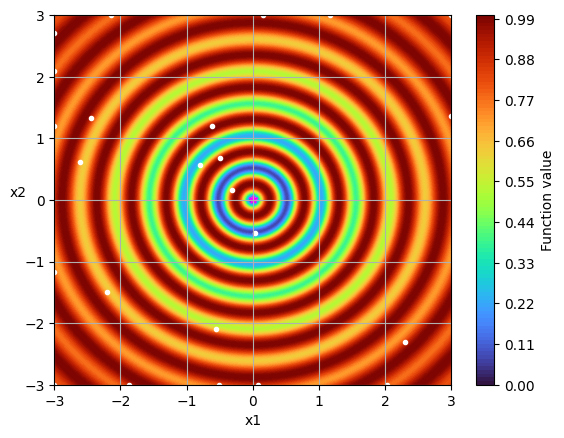

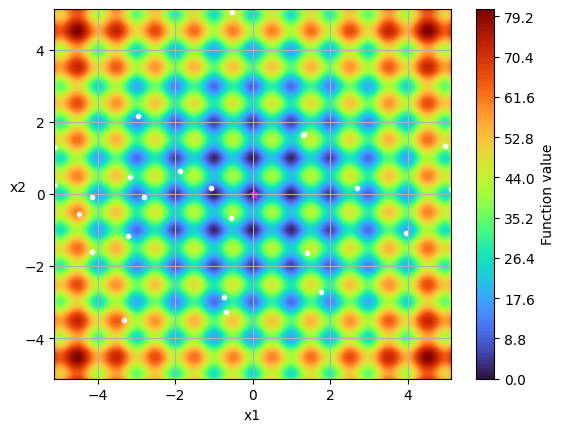

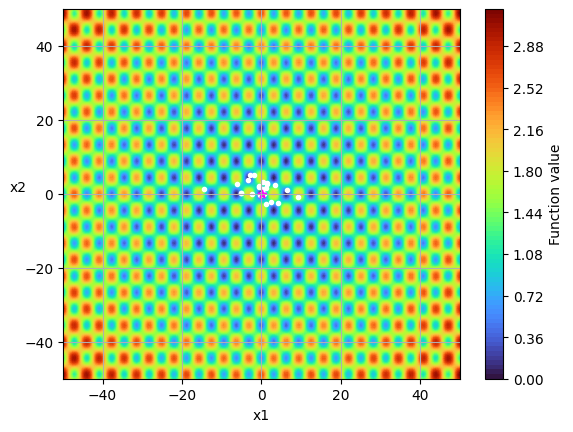

In [286]:
# pop = Evolution(Griewank(GRIE_BOUNDS, DIMENSIONS), ITERATIONS, POPULATION, PM, PC, SIGMA)
# pop.fitness_func()
# for particle in pop.population():
#     print(f'x1, x2 = ({particle.position()}), q = {particle.value()}')

# post_mut_pop = copy.deepcopy(pop)
# for particle in post_mut_pop.population():
#     post_mut_pop.mutation(particle)

# differents = []
# for i in range(POPULATION):
#     part = pop.population()[i]
#     mut_part = post_mut_pop.population()[i]
#     delta = part.position()[0] - mut_part.position()[0]
#     if delta > 0.01:
#         differents.append(i)
#     print(f'x1, x2 = {part.position()} | {mut_part.position()},\t q = {part.value()} | {mut_part.value()}')

# print(differents)



# p1 = Particle(1, [1.1, -0.3], Griewank([-5, 5], 2))
# p2 = Particle(2, [0.0, -0.1], Griewank([-5, 5], 2))
# p3 = Particle(3, [2.0,  0.0], Griewank([-5, 5], 2))

# population = [p1, p2, p3]

# for p in population:
#     p.print()
# print('\n')

# for p in population:
#     p.set_value()
#     p.print()
# print('\n')

# population.sort(key = lambda x: x.value())

# for p in population:
#     p.print()



testfu = DropWave(DROP_BOUNDS, DIMENSIONS)
pop = Evolution(testfu, ITERATIONS, POPULATION, PM, PC, SIGMA)
plot = Plotter(testfu, PLOT_STEPS)
best_fitnesses = []
t = 0
while t < pop.iterations():
    # plot.draw_online(pop)
    # print('\n', t)
    pop.fitness_func()
    pop.reproduction()
    for particle in pop.population():
        pop.crossover(particle)
        pop.mutation(particle)
    pop.succession()

    best_fitnesses.append(pop.best_fitness().value())
    # print(pop.best_fitness().value())
    t += 1
plot.draw_online(pop)

testfu = Rastrigin(RAST_BOUNDS, DIMENSIONS)
pop = Evolution(testfu, ITERATIONS, POPULATION, PM, PC, SIGMA)
plot = Plotter(testfu, PLOT_STEPS)
best_fitnesses = []
t = 0
while t < pop.iterations():
    # plot.draw_online(pop)
    # print('\n', t)
    pop.fitness_func()
    pop.reproduction()
    for particle in pop.population():
        pop.crossover(particle)
        pop.mutation(particle)
    pop.succession()

    best_fitnesses.append(pop.best_fitness().value())
    # print(pop.best_fitness().value())
    t += 1
plot.draw_online(pop)
    # TRZEBA POPRAWIĆ TO ŻE WARTOŚCI NIE SĄ NIEOSNĄCE PO KAŻDEJ ITERACJI


testfu = Griewank(GRIE_BOUNDS, DIMENSIONS)
pop = Evolution(testfu, ITERATIONS, POPULATION, PM, PC, SIGMA)
plot = Plotter(testfu, PLOT_STEPS)
best_fitnesses = []
t = 0
while t < pop.iterations():
    # plot.draw_online(pop)
    # print('\n', t)
    pop.fitness_func()
    pop.reproduction()
    for particle in pop.population():
        pop.crossover(particle)
        pop.mutation(particle)
    pop.succession()

    best_fitnesses.append(pop.best_fitness().value())
    # print(pop.best_fitness().value())
    t += 1
plot.draw_online(pop)